#### **SAGEMAKER - BYOS CONFIGURATION FOR PYTORCH**

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore
import torch
import os
import re
import json
import time
import seaborn as sns

from io import StringIO
from smart_open import smart_open

from IPython.core.display import display, HTML

config = botocore.config.Config()
sm = boto3.client(service_name = 'sagemaker', config = config)
sm_runtime = boto3.client('sagemaker-runtime', config = config)
sess = sagemaker.Session(sagemaker_client = sm, sagemaker_runtime_client = sm_runtime)

with open('/'.join(os.getcwd().split('/')[:-1])+'/params.json','r') as params:
    params = json.load(params)

bucket = params['sm_role']
default_bucket = sess.default_bucket()
role = params['sm_role'] #sagemaker.get_execution_role()
region = sess.boto_region_name

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

####
#### **CONFIGURE DATASET**

In [3]:
processed_csv_train = 's3://{}/data/processed/csv/train'.format(bucket)
processed_csv_validation = 's3://{}/data/processed/csv/validation'.format(bucket)
processed_csv_evaluation = 's3://{}/data/processed/csv/evaluation'.format(bucket)

In [8]:
!aws s3 cp --recursive ./data/processed/csv/train $processed_csv_train
!aws s3 cp --recursive ./data/processed/csv/validation $processed_csv_validation
!aws s3 cp --recursive ./data/processed/csv/evaluation $processed_csv_evaluation

upload: data/processed/csv/train/train.csv to s3://hwm-nba/data/processed/csv/train/train.csv
upload: data/processed/csv/validation/validation.csv to s3://hwm-nba/data/processed/csv/validation/validation.csv
upload: data/processed/csv/evaluation/evaluation.csv to s3://hwm-nba/data/processed/csv/evaluation/evaluation.csv


In [10]:
!aws s3 ls --recursive $processed_csv_train
!aws s3 ls --recursive $processed_csv_validation
!aws s3 ls --recursive $processed_csv_evaluation

2022-10-26 22:59:43     530310 data/processed/csv/train/train.csv
2022-10-26 22:59:46      59073 data/processed/csv/validation/validation.csv
2022-10-26 22:59:48      59073 data/processed/csv/evaluation/evaluation.csv


####
#### **OPTIONALLY ETL THE DATA TO THE TFRECORDS FORMAT**

In [4]:
train = pd.read_csv(smart_open(processed_csv_train+'/train.csv'))
validation = pd.read_csv(smart_open(processed_csv_validation+'/validation.csv'))
evaluation = pd.read_csv(smart_open(processed_csv_evaluation+'/evaluation.csv'))

In [12]:
def csv_to_tfrecords(data,path):
    with tf.io.TFRecordWriter(path) as file_writer:
        for i in range(len(data)): #4):
            x = data.iloc[i,:-1].to_numpy().tobytes() #[np.random.random(),np.random.random()]
            y = data.iloc[i, -1].astype('int64') #.to_numpy()  #np.random.random()
            
            mystring = tf.train.Example(features=tf.train.Features(feature={
                'x': tf.train.Feature(bytes_list=tf.train.BytesList(value=[x])),
                'y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])),
            })).SerializeToString()
            file_writer.write(mystring)

In [22]:
os.makedirs('./data/processed/tfrecords/train/', exist_ok = True)
os.makedirs('./data/processed/tfrecords/validation/', exist_ok = True)
os.makedirs('./data/processed/tfrecords/evaluation/', exist_ok = True)

In [23]:
csv_to_tfrecords(train,'./data/processed/tfrecords/train/train.tfrecords')
csv_to_tfrecords(validation,'./data/processed/tfrecords/validation/validation.tfrecords')
csv_to_tfrecords(evaluation,'./data/processed/tfrecords/evaluation/evaluation.tfrecords')

In [24]:
processed_tfrecords_train = 's3://{}/data/processed/tfrecords/train'.format(bucket)
processed_tfrecords_validation = 's3://{}/data/processed/tfrecords/validation'.format(bucket)
processed_tfrecords_evaluation = 's3://{}/data/processed/tfrecords/evaluation'.format(bucket)

In [25]:
!aws s3 cp --recursive ./data/processed/tfrecords/train $processed_tfrecords_train
!aws s3 cp --recursive ./data/processed/tfrecords/validation $processed_tfrecords_validation
!aws s3 cp --recursive ./data/processed/tfrecords/evaluation $processed_tfrecords_evaluation

upload: data/processed/tfrecords/train/train.tfrecords to s3://hwm-nba/data/processed/tfrecords/train/train.tfrecords
upload: data/processed/tfrecords/validation/validation.tfrecords to s3://hwm-nba/data/processed/tfrecords/validation/validation.tfrecords
upload: data/processed/tfrecords/evaluation/evaluation.tfrecords to s3://hwm-nba/data/processed/tfrecords/evaluation/evaluation.tfrecords


In [5]:
s3_input_train_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_csv_train
)

s3_input_validation_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_csv_validation
)

s3_input_evaluation_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_csv_evaluation
)

In [6]:
data_channels = {
    'train': s3_input_train_data,
    'validation': s3_input_validation_data,
    'eval': s3_input_evaluation_data
}

####
#### **HYPERPARAMETERS**

In [7]:
seed = 42
epochs = 5
batch_size = 500
#learning_rate = 2e-5
train_batch_size = 500
#train_steps_per_epoch = 180
validation_batch_size = 500
#validation_steps_per_epoch = 20
run_validation = 1

train_instance_count = 1
train_instance_type = 'ml.m4.xlarge' #'ml.c5.9xlarge' #ml.t3.medium' #'ml.c5.9xlarge'
train_volume_size = 256
input_mode = 'File'

In [8]:
hyperparameters = {
    'epochs': epochs,
    'batch-size': batch_size,
    'train-batch-size': train_batch_size,
    'validation-batch-size': validation_batch_size,
    'seed': seed,
    'run-validation': run_validation
}

In [501]:
# metric definitions for cloudwatch
metric_definitions = [
     {'Name': 'validation:loss', 'Regex': 'validation loss: ([0-9.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'validation accuracy: ([0-9.]+)'}
]

####
#### **DEBUGGER RULES**

In [502]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

In [503]:
# provides options to customize how debugging information is emitted and saved
debugger_hook_config = DebuggerHookConfig(
    s3_output_path='s3://{}'.format(bucket),
)

In [504]:
# ProfilerConfig sets the configuration for collecting system and framework metrics of SageMaker Training Jobs.
# Parameter `system_monitor_interval_millis` sets the time interval to collect system metrics (in milliseconds).
# Parameter `framework_profile_params` is the object for framework metrics profiling. Here you will set its local path,
# the step at which to start profiling, `start_step`, and the number of steps to profile, `num_steps`.

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path='/opt/ml/output/profiler/', start_step=5, num_steps=10)
)

In [505]:
# For monitoring and profiling the built-in rules you can use the `ProfilerReport`.
# It creates a profiling report and updates when the individual rules are triggered.
# If you trigger this `ProfilerReport` rule without any customized parameter as in the cell below,
# then the `ProfilerReport` rule triggers all of the built-in rules for monitoring and profiling with their default parameter values.
# The profiling report can be downloaded while the Training Job is running or after the job has finished.

rules = [ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

####
#### **TRAIN MODEL USING train.py SCRIPT**

In [506]:
use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    script_mode=True,
    base_job_name = 'nba-test',
    source_dir = 'code',
    entry_point='train.py',
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    py_version='py36',
    framework_version='1.6.0',
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    input_mode=input_mode,
    debugger_hook_config=debugger_hook_config,
    use_spot_instances = use_spot_instances,
    profiler_config=profiler_config,
    rules=rules,
    max_run=max_run,
    max_wait=max_wait
)

In [507]:
estimator.fit(
    inputs = data_channels,
    wait = False
)

In [508]:
training_job_name = estimator.latest_training_job.name
print('Training Job name: {}'.format(training_job_name))

Training Job name: nba-test-2022-10-29-21-49-07-189


In [509]:
training_job_status_primary = estimator.latest_training_job.describe()['TrainingJobStatus']
print('Training Job status: {}'.format(training_job_status_primary)+'\n')
print('SageMaker Training Job: https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}'.format(region, training_job_name)+'\n')
print('CloudWatch Logs: https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix'.format(region, training_job_name)+'\n')
print('S3 Output Data: https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview'.format(bucket, training_job_name, region)+'\n')


Training Job status: InProgress

SageMaker Training Job: https://console.aws.amazon.com/sagemaker/home?region=us-west-2#/jobs/nba-test-2022-10-29-21-49-07-189

CloudWatch Logs: https://console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/TrainingJobs;prefix=nba-test-2022-10-29-21-49-07-189;streamFilter=typeLogStreamPrefix

S3 Output Data: https://s3.console.aws.amazon.com/s3/buckets/hwm-nba/nba-test-2022-10-29-21-49-07-189/?region=us-west-2&tab=overview



In [510]:
%%time
# this cell takes a while to run
estimator.latest_training_job.wait(logs=False)


2022-10-29 21:49:08 Starting - Starting the training job....
2022-10-29 21:49:33 Starting - Preparing the instances for training..............
2022-10-29 21:50:46 Downloading - Downloading input data.....
2022-10-29 21:51:17 Training - Downloading the training image............
2022-10-29 21:52:27 Training - Training image download completed. Training in progress.......
2022-10-29 21:53:03 Uploading - Uploading generated training model..
2022-10-29 21:53:18 Completed - Training job completed
CPU times: user 364 ms, sys: 182 ms, total: 546 ms
Wall time: 4min 10s


In [511]:
df_metrics = estimator.training_job_analytics.dataframe()
df_metrics

,timestamp,metric_name,value
0,0.0,validation:loss,0.3754
1,0.0,validation:accuracy,0.9242


<AxesSubplot:xlabel='timestamp'>

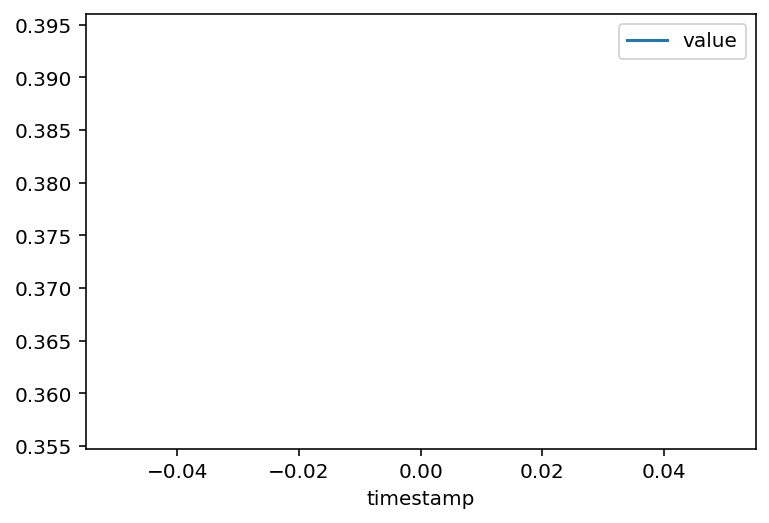

In [512]:
df_metrics.query("metric_name=='validation:loss'").plot(x='timestamp', y='value')

In [513]:
print('Debugger Output: https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/'.format(bucket, training_job_name))

Debugger Output: https://s3.console.aws.amazon.com/s3/buckets/hwm-nba?prefix=nba-test-2022-10-29-21-49-07-189/


####
#### **VIEW DEBUGGER RESULTS**

In [514]:
s3 = boto3.Session().resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())

for my_bucket_object in my_bucket.objects.filter(Prefix=training_job_name): #.all():
    if re.search('rule-output.*profiler-output',my_bucket_object.key):
        mypath = my_bucket_object.key
        mypath = mypath.split('profiler-output/')[0]+'profiler-output/'
        break
    
profiler_report_s3_uri = ('s3://{}/'+mypath).format(sess.default_bucket())

In [515]:
profiler_report_s3_uri

's3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/rule-output/ProfilerReport/profiler-output/'

The folder `profiler-reports` contains the built-in rule analysis components, stored in JSON and a Jupyter notebook. They are aggregated into the report.

In [516]:
!aws s3 cp --recursive $profiler_report_s3_uri ./profiler_report/
print('\nProfiler Report: ./profiler_report/profiler-report.html')

download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to profiler_report/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to profiler_report/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to profiler_report/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to profiler_report/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemory

####
#### **DEPLOYING THE MODEL**

In [517]:
estimator.model_data

's3://sagemaker-us-west-2-668209712187/nba-test-2022-10-29-21-49-07-189/output/model.tar.gz'

In [518]:
from sagemaker.pytorch.model import PyTorchModel
pytorch_model_name = 'pytorch-test3'

pytorch_model = PyTorchModel(
    name = pytorch_model_name,
    model_data = estimator.model_data,
    #predictor_cls = NumpyPredictor,
    entry_point = 'inference.py',
    source_dir = 'code',
    framework_version = '1.6.0',
    py_version = 'py36',
    role = role
)

In [519]:
%%time

pytorch_endpoint_name = 'nba-sexy-endpoint-pytorch'

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name=pytorch_endpoint_name
)

Using already existing model: pytorch-test3


------!CPU times: user 651 ms, sys: 245 ms, total: 896 ms
Wall time: 3min 7s


In [520]:
# sm.delete_endpoint_config(EndpointConfigName='nba-sexy-endpoint-pytorch')

In [521]:
print('Review Endpoint: https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}'.format(region, pytorch_endpoint_name))

Review Endpoint: https://console.aws.amazon.com/sagemaker/home?region=us-west-2#/endpoints/nba-sexy-endpoint-pytorch


####
#### **TESTING ON UNSEEN DATA**

In [522]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch.model import PyTorchPredictor
from sagemaker.serializers import CSVSerializer,JSONSerializer,JSONLinesSerializer,NumpySerializer
from sagemaker.deserializers import JSONDeserializer,JSONLinesDeserializer

class NumpyPredictor(Predictor):
    def __init__(self, endpoint_name, sess):
        super().__init__(endpoint_name,
                         sagemaker_session=sess,
                         serializer=NumpySerializer(),
                         deserializer=JSONDeserializer())

In [523]:
predictor = NumpyPredictor(pytorch_endpoint_name, sess)

In [524]:
inputs = pd.read_csv('./data/processed/csv/train/train.csv').iloc[:,:-1].to_numpy()
inputs

array([[0.70644922, 0.72160229, 0.63636364, 0.27058824, 0.        ],
       [0.4306894 , 0.40217453, 0.53246753, 0.76470588, 0.01851852],
       [0.63306153, 0.63708155, 0.49350649, 0.43529412, 0.24074074],
       ...,
       [0.56338028, 0.54855508, 0.35064935, 0.44705882, 0.40740741],
       [0.74054855, 0.76211731, 0.46753247, 0.30588235, 0.        ],
       [0.44032617, 0.4139628 , 0.37662338, 0.36470588, 0.        ]])

In [525]:
predicted_classes = predictor.predict(inputs)

In [526]:
len(predicted_classes['predictions'])

9000

In [543]:
for predicted_class in predicted_classes['probs'][:10]:
    p = predicted_class[0]
    print("Predicted class {} with probability {:.2%}".format(int(np.round(p)),np.round(max(p,1-p),5)))

Predicted class 0 with probability 87.69%
Predicted class 1 with probability 93.37%
Predicted class 0 with probability 87.43%
Predicted class 1 with probability 98.63%
Predicted class 0 with probability 62.12%
Predicted class 1 with probability 93.88%
Predicted class 0 with probability 75.31%
Predicted class 1 with probability 70.25%
Predicted class 1 with probability 80.78%
Predicted class 0 with probability 51.50%


In [529]:
preds = [np.round(v[0]) for v in predicted_classes['predictions']]

ground_truth = pd.read_csv('./data/processed/csv/train/train.csv').iloc[:,:]
preds = pd.concat([ground_truth,pd.DataFrame(preds,columns=['pred'])],axis=1)

In [530]:
preds

,diameter,weight,red,green,blue,is_orange,pred
0,0.706449,0.721602,0.636364,0.270588,0.000000,0,0
1,0.430689,0.402175,0.532468,0.764706,0.018519,1,1
2,0.633062,0.637082,0.493506,0.435294,0.240741,0,0
3,0.243884,0.190844,0.636364,0.647059,0.055556,1,1
4,0.546331,0.528298,0.376623,0.400000,0.000000,0,0
...,...,...,...,...,...,...,...
8995,0.428466,0.399313,0.350649,0.635294,0.000000,1,1
8996,0.512973,0.500715,0.441558,0.717647,0.222222,1,1
8997,0.563380,0.548555,0.350649,0.447059,0.407407,0,0
8998,0.740549,0.762117,0.467532,0.305882,0.000000,0,0


Text(0.5, 1.0, 'Confusion Matrix')

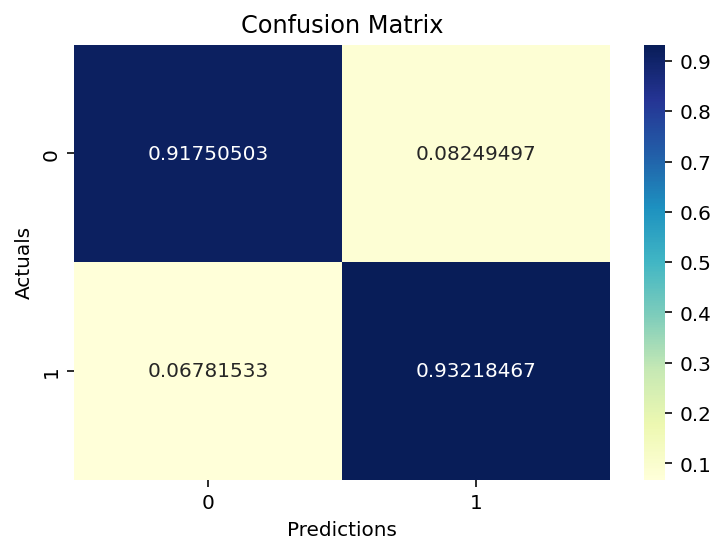

In [531]:
confusion_matrix = pd.crosstab(
    preds['is_orange'],
    preds['pred'],
    rownames=['Actuals'],
    colnames=['Predictions'],
    normalize='index',
)
sns.heatmap(confusion_matrix, annot = True, fmt = '.8f', cmap = 'YlGnBu').set_title('Confusion Matrix')

In [532]:
sess.delete_endpoint(predictor.endpoint_name)